In [1]:
import pandas as pd
import pygris
import censusdata

/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
heat_island_data = pd.read_csv('UHI effect by census tract-Table 1.csv')

In [3]:
heat_island_data['census tract number'] = heat_island_data['census tract number'].astype(str)

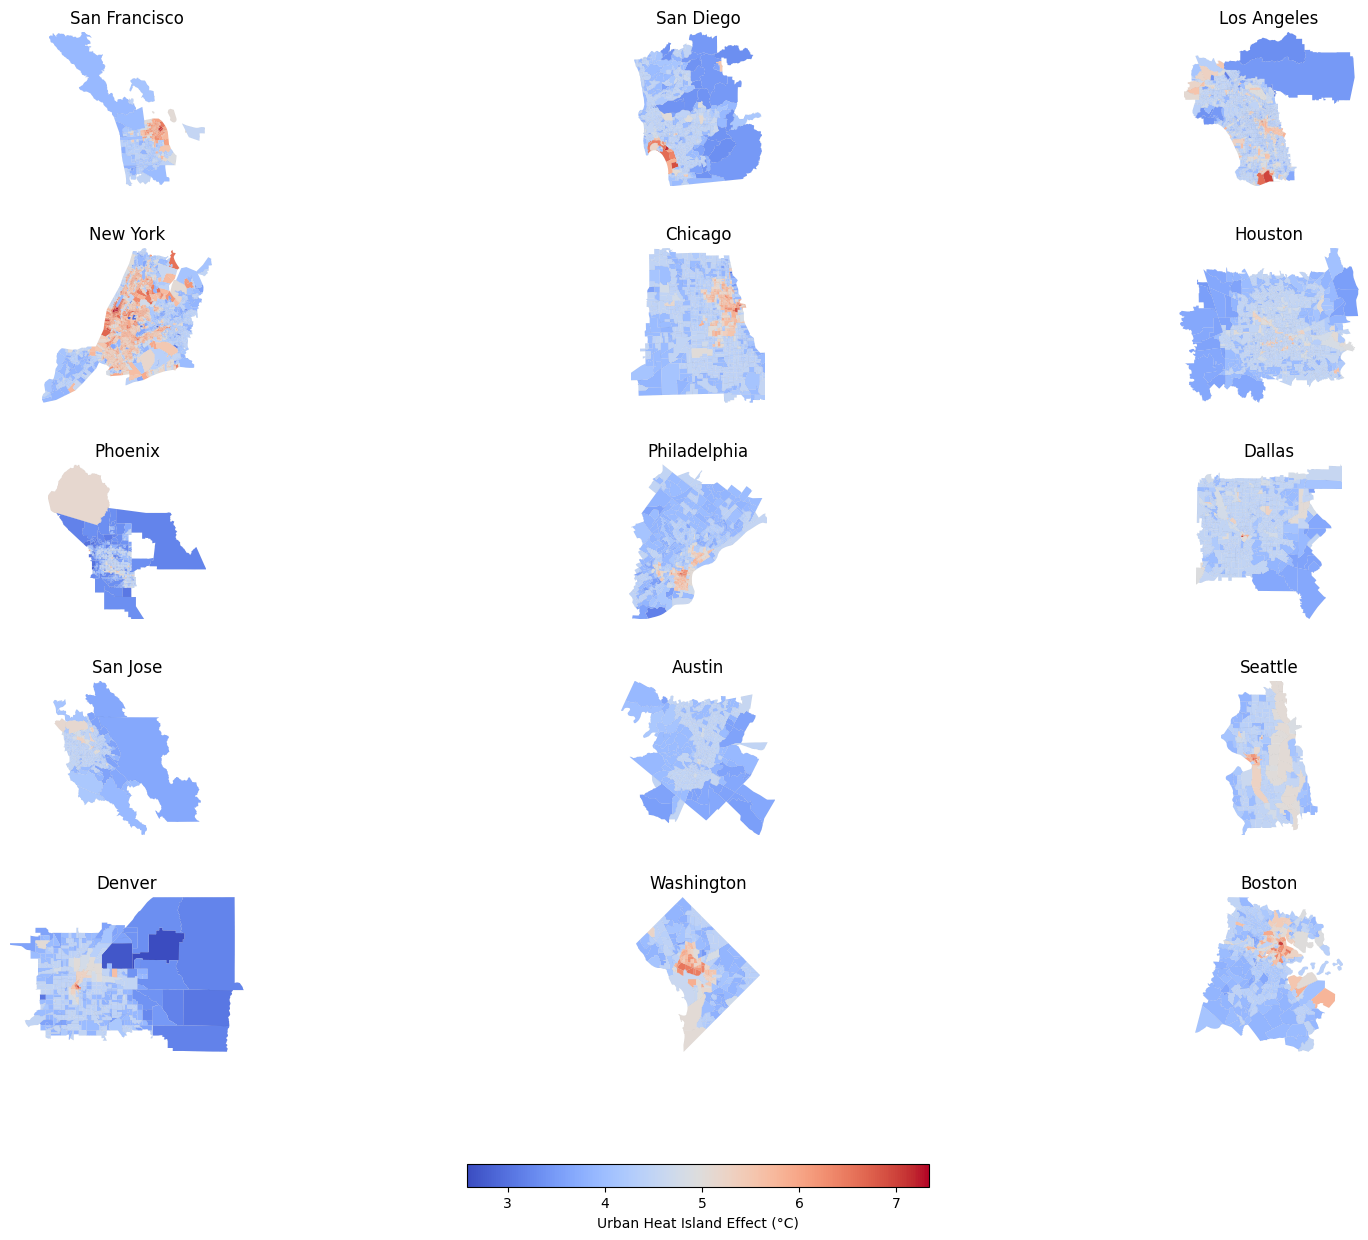

In [15]:
import pandas as pd
import censusdata
from pygris import tracts
import geopandas as gpd
import matplotlib.pyplot as plt

# Function to load tracts for a given state
def load_tracts(state_code):
    return tracts(state=state_code, year=2020)

# Dictionary of cities and their state codes (using FIPS codes)
cities_states = {
    'San Francisco': '06',  # California
    'San Diego': '06',  # California
    'Los Angeles': '06',  # California
    'New York': '36',  # New York
    'Chicago': '17',  # Illinois
    'Houston': '48',  # Texas
    'Phoenix': '04',  # Arizona
    'Philadelphia': '42',  # Pennsylvania
    'Dallas': '48',  # Texas
    'San Jose': '06',  # California
    'Austin': '48',  # Texas
    'Seattle': '53',  # Washington
    'Denver': '08',  # Colorado
    'Washington': '11',  # DC
    'Boston': '25'  # Massachusetts
}


# Download ACS 5-year 2020 data for demographics
variables = {
    'population': 'B01003_001E',
    'median_income': 'B19013_001E',
}

# Function to get ACS data for a state
def get_acs_data(state_code):
    return censusdata.download('acs5', 2020, censusdata.censusgeo([('state', state_code), ('county', '*'), ('tract', '*')]), list(variables.values()))

# Load census tracts and ACS data for all states
tracts_gdfs = {}
acs_data = pd.DataFrame()
for city, state in cities_states.items():
    if state not in tracts_gdfs:
        tracts_gdfs[state] = load_tracts(state)
        state_data = get_acs_data(state)
        state_data.columns = list(variables.keys())
        state_data.reset_index(inplace=True)
        state_data['GEOID'] = state_data['index'].apply(lambda x: ''.join([g[1] for g in x.geo]))
        acs_data = pd.concat([acs_data, state_data])

# Load urban heat island data
heat_island_data = pd.read_csv('UHI effect by census tract-Table 1.csv')
heat_island_data['census tract number'] = heat_island_data['census tract number'].astype(str)
heat_island_data['census tract number'] = heat_island_data['census tract number'].str.zfill(11)

# Merge datasets
merged_data = pd.merge(heat_island_data, acs_data, left_on='census tract number', right_on='GEOID')

# Merge with tracts to get geometry
merged_gdf = pd.DataFrame()
for state, tracts_gdf in tracts_gdfs.items():
    state_gdf = tracts_gdf[tracts_gdf['GEOID'].isin(merged_data['GEOID'])].copy()
    state_gdf = state_gdf.merge(merged_data, on='GEOID')
    merged_gdf = pd.concat([merged_gdf, state_gdf])

# Convert merged_gdf to GeoDataFrame
merged_gdf = gpd.GeoDataFrame(merged_gdf, geometry='geometry')

# List of cities for analysis
cities = list(cities_states.keys())

# Set up the figure and axes for the grid of maps
fig, axes = plt.subplots(5, 3, figsize=(20, 15))  # 2 rows, 3 columns for the grid layout

# Create a color map and normalization for consistent legend
norm = plt.Normalize(merged_gdf['urban heat island effect (temperature in degrees C)'].min(),
                     merged_gdf['urban heat island effect (temperature in degrees C)'].max())
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])  # Only needed for the colorbar


# Plot each city
axes = axes.flatten()

# Plot each city
for ax, city in zip(axes, cities):
    city_gdf = merged_gdf[merged_gdf['city'].str.contains(city, case=False, na=False)]
    if not city_gdf.empty:
        city_gdf.plot(column='urban heat island effect (temperature in degrees C)', 
                      cmap='coolwarm', ax=ax, edgecolor='black', norm=norm, linewidth = 0.01)
        ax.set_title(f'{city}')
        
        # Dynamically set limits based on city data
        x_min, y_min, x_max, y_max = city_gdf.total_bounds
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
    else:
        ax.set_title(f'No Data for {city}')  # Handle empty data case

    ax.set_axis_off()  # Turn off axis for cleaner look

# Remove any unused subplots
for ax in axes[len(cities):]:
    ax.remove()

# Add a single legend to the figure
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.02, pad=0.1)
cbar.set_label('Urban Heat Island Effect (°C)')

# Adjust layout
plt.subplots_adjust(wspace=0.4, hspace=0.4, bottom=0.2)  # Adjust space between plots and add bottom margin
plt.show()


In [ ]:
import pandas as pd
import censusdata
from pygris import tracts
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Function to load tracts for a given state
def load_tracts(state_code):
    return tracts(state=state_code, year=2020)

# Dictionary of cities and their state codes (using FIPS codes)
# Dictionary of cities and their state codes (using FIPS codes)
cities_states = {
    'San Francisco': '06',  # California
    'San Diego': '06',  # California
    'Los Angeles': '06',  # California
    'New York': '36',  # New York
    'Chicago': '17',  # Illinois
    'Houston': '48',  # Texas
    'Phoenix': '04',  # Arizona
    'Philadelphia': '42',  # Pennsylvania
    'Dallas': '48',  # Texas
    'San Jose': '06',  # California
    'Austin': '48',  # Texas
    'Seattle': '53',  # Washington
    'Denver': '08',  # Colorado
    'Washington': '11',  # DC
    'Boston': '25'  # Massachusetts
}
# Download ACS 5-year 2020 data for demographics
variables = {
    'population': 'B01003_001E',
    'median_income': 'B19013_001E',
}

# Function to get ACS data for a state
def get_acs_data(state_code):
    return censusdata.download('acs5', 2020, censusdata.censusgeo([('state', state_code), ('county', '*'), ('tract', '*')]), list(variables.values()))

# Load census tracts and ACS data for all states
tracts_gdfs = {}
acs_data = pd.DataFrame()
for city, state in cities_states.items():
    if state not in tracts_gdfs:
        tracts_gdfs[state] = load_tracts(state)
        state_data = get_acs_data(state)
        state_data.columns = list(variables.keys())
        state_data.reset_index(inplace=True)
        state_data['GEOID'] = state_data['index'].apply(lambda x: ''.join([g[1] for g in x.geo]))
        acs_data = pd.concat([acs_data, state_data])

# Load urban heat island data
heat_island_data = pd.read_csv('UHI effect by census tract-Table 1.csv')
heat_island_data['census tract number'] = heat_island_data['census tract number'].astype(str)
heat_island_data['census tract number'] = heat_island_data['census tract number'].str.zfill(11)

# Merge datasets
merged_data = pd.merge(heat_island_data, acs_data, left_on='census tract number', right_on='GEOID')

# Merge with tracts to get geometry
merged_gdf = pd.DataFrame()
for state, tracts_gdf in tracts_gdfs.items():
    state_gdf = tracts_gdf[tracts_gdf['GEOID'].isin(merged_data['GEOID'])].copy()
    state_gdf = state_gdf.merge(merged_data, on='GEOID')
    merged_gdf = pd.concat([merged_gdf, state_gdf])

# Convert merged_gdf to GeoDataFrame
merged_gdf = gpd.GeoDataFrame(merged_gdf, geometry='geometry')

# Calculate the percentage of the population in high urban heat index areas
high_heat_percentages = {}

for city in cities_states.keys():
    city_gdf = merged_gdf[merged_gdf['city'].str.contains(city, case=False, na=False)]
    if not city_gdf.empty:
        # Determine the threshold for high urban heat index (top 25%)
        threshold = np.percentile(city_gdf['urban heat island effect (temperature in degrees C)'], 75)
        high_heat_gdf = city_gdf[city_gdf['urban heat island effect (temperature in degrees C)'] >= threshold]
        
        # Calculate the percentage of the population in high urban heat index areas
        total_population = city_gdf['population'].sum()
        high_heat_population = high_heat_gdf['population'].sum()
        high_heat_percentages[city] = (high_heat_population / total_population) * 100


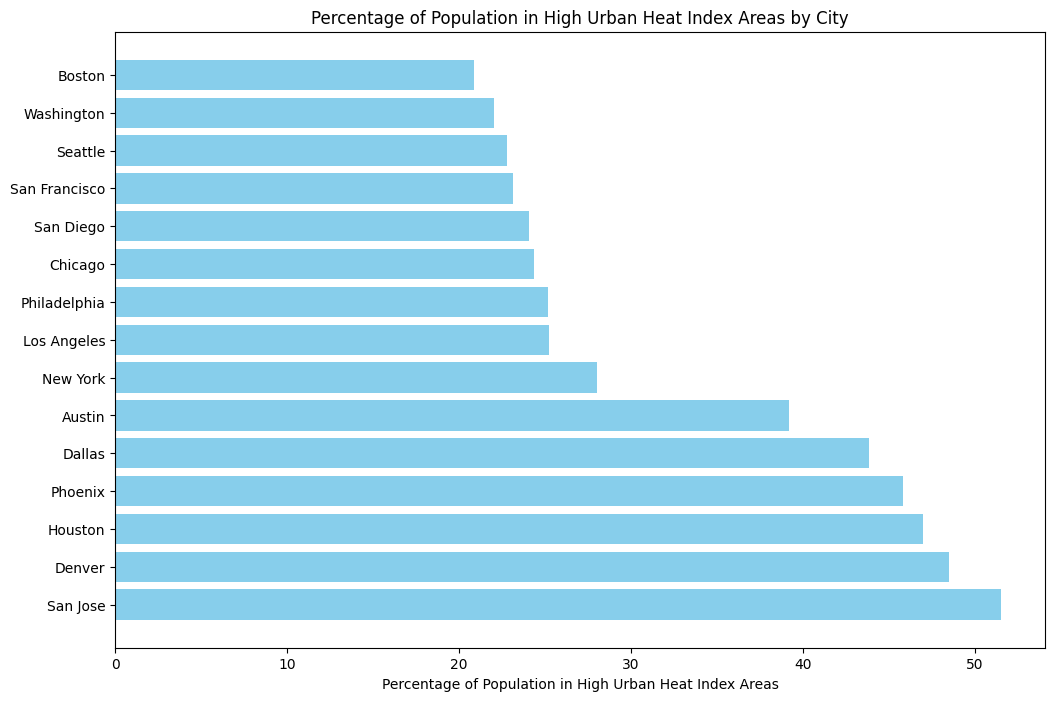

In [6]:
# Plot the percentages
fig, ax = plt.subplots(figsize=(12, 8))
cities = list(sorted_percentages.keys())
percentages = list(sorted_percentages.values())

ax.barh(cities, percentages, color='skyblue')
ax.set_xlabel('Percentage of Population in High Urban Heat Index Areas')
ax.set_title('Percentage of Population in High Urban Heat Index Areas by City')
plt.show()